**To-do List**  

- 우선 BYOL-A 저자들이 제공하는 Augmentation 모듈로 실험중.   
  모든 과정이 정상적으로 실행되면 patch-mix_contrastive_learning/util
/augmentation.py 적용 -> 일단 취소
- ICBHI 전체 데이터에 대해 적용 (진행중, PM 3:00~)  
- t-SNE 시각화  

In [1]:
!pip install torch torchaudio torchvision pyyaml pytorch_lightning librosa easydict tqdm wandb

In [2]:
import os
import sys
import shutil
import random
import re
import logging
import yaml
import datetime
import pickle
import librosa
from pathlib import Path
from easydict import EasyDict
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
import torchaudio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim

import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelSummary, LearningRateMonitor
from sklearn.metrics import confusion_matrix

In [3]:
from google.colab import drive

drive.mount('/content/drive')

# ICBHI_TRAIN_PATH = "/content/drive/MyDrive/ADV 프로젝트/data/sample_test"
ICBHI_TRAIN_PATH = "/content/drive/MyDrive/ADV 프로젝트/data/ICBHI/train"
ICBHI_FINETUNING_TRAIN_PATH = "/content/drive/MyDrive/ADV 프로젝트/data/ICBHI/ft_train"
ICBHI_FINETUNING_VALID_PATH = "/content/drive/MyDrive/ADV 프로젝트/data/ICBHI/ft_valid"
ICBHI_TEST_PATH = "/content/drive/MyDrive/ADV 프로젝트/data/ICBHI/test"
PRETRAINED_MODEL_PATH = "/content/drive/MyDrive/ADV 프로젝트/checkpoints"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!wandb login

wandb: Currently logged in as: vanillahub12 (boaz_woony-boaz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 1. 사전훈련 데이터 EDA

#### 1-1. 데이터셋 구성 및 확인

In [5]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

root = ICBHI_TRAIN_PATH
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

i_list = []
train_rec_annotations = []
train_rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    train_rec_annotations.append(a)
    train_rec_annotations_dict[s] = a

duration_list = []
for i in range(len(train_rec_annotations)):
    current = train_rec_annotations[i]
    duration = current['End'] - current['Start']
    duration_list.extend(duration)

In [6]:
train_rec_annotations_dict['101_1b1_Al_sc_Meditron']

,Start,End,Crackles,Wheezes
0,0.036,0.579,0,0
1,0.579,2.450,0,0
2,2.450,3.893,0,0
3,3.893,5.793,0,0
4,5.793,7.521,0,0
5,7.521,9.279,0,0
6,9.279,11.150,0,0
7,11.150,13.036,0,0
8,13.036,14.721,0,0
9,14.721,16.707,0,0


In [7]:
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,134,2b1,Ar,mc,LittC2SE
0,134,2b2,Al,mc,LittC2SE
0,134,2b3,Ar,mc,LittC2SE
0,134,2b2,Ar,mc,LittC2SE
0,135,2b1,Al,mc,LittC2SE


#### 1-2. 호흡 주기 분포 확인

longest cycle:16.163
shortest cycle:0.228
Fraction of samples less than 5 seconds:0.9711667411712115


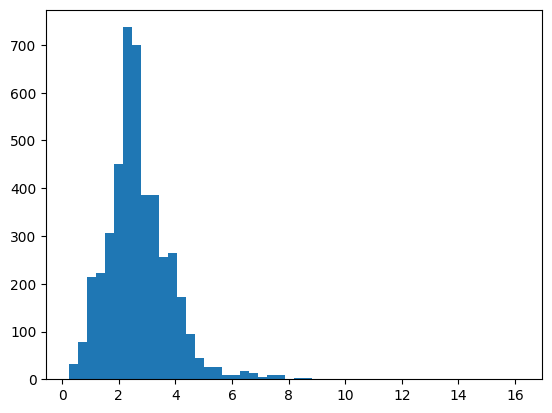

In [8]:
duration_list = np.array(duration_list)
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
threshold = 5
print('Fraction of samples less than {} seconds:{}'.format(threshold, np.sum(duration_list < threshold)/len(duration_list)))

In [9]:
len(duration_list)

4474

#### 1-3. Label 분포 확인

In [10]:
no_label_list = []    # Normal
crack_list = []       # Crackle Only
wheeze_list = []      # Wheeze Only
both_sym_list = []    # Both
filename_list = []    # 데이터 이름

for f in filenames:
    d = train_rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [11]:
file_label_df = pd.DataFrame(data = {'filename':filename_list, 'no label':no_label_list, 'crackles only':crack_list, 'wheezes only':wheeze_list, 'crackles and wheezees':both_sym_list})
file_label_df.head()

,filename,no label,crackles only,wheezes only,crackles and wheezees
0,134_2b1_Ar_mc_LittC2SE,5,0,0,0
1,134_2b2_Al_mc_LittC2SE,7,0,0,0
2,134_2b3_Ar_mc_LittC2SE,5,0,1,0
3,134_2b2_Ar_mc_LittC2SE,7,0,0,0
4,135_2b1_Al_mc_LittC2SE,9,0,0,0


## 2. 데이터 전처리  

#### 2-1. 호흡 주기 분할

In [12]:
def _slice_data_torchaudio(start, end, data, sample_rate):
    """
    SCL paper..
    sample_rate denotes how many sample points for one second
    """
    max_ind = len(data)
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)

    return data[start_ind: end_ind]


def _get_lungsound_label(crackle, wheeze):
    if crackle == 0 and wheeze == 0:
        return 0
    elif crackle == 1 and wheeze == 0:
        return 1
    elif crackle == 0 and wheeze == 1:
        return 2
    elif crackle == 1 and wheeze == 1:
        return 3


def get_individual_cycles_torchaudio(recording_annotations, wav, sample_rate):
    """
    SCL paper..
    used to split each individual sound file into separate sound clips containing one respiratory cycle each
    output: [(audio_chunk:np.array, label:int), (...)]
    """
    sample_data = []
    # fpath = os.path.join(data_folder, filename)

    # sr = librosa.get_samplerate(fpath)
    # data, _ = torchaudio.load(fpath)

    for idx in recording_annotations.index:
        row = recording_annotations.loc[idx]

        start = row['Start'] # time (second)
        end = row['End'] # time (second)
        audio_chunk = _slice_data_torchaudio(start, end, wav, sample_rate)

        crackles = row['Crackles']
        wheezes = row['Wheezes']
        sample_data.append((audio_chunk, _get_lungsound_label(crackles, wheezes)))

    return sample_data

#### 2-2. Log mel spectrogram 변환  
- WaveInLMSOutDataset 클래스 정의  
- zero-padding, random crop을 통한 전처리 방법 정의

In [13]:
class MelSpectrogramLibrosa:
    """Mel spectrogram using librosa."""
    def __init__(self, fs=16000, n_fft=1024, shift=160, n_mels=64, fmin=60, fmax=7800):
        self.fs, self.n_fft, self.shift, self.n_mels, self.fmin, self.fmax = fs, n_fft, shift, n_mels, fmin, fmax
        self.mfb = librosa.filters.mel(sr=fs, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax)

    def __call__(self, audio):
        X = librosa.stft(np.array(audio), n_fft=self.n_fft, hop_length=self.shift)
        return torch.tensor(np.matmul(self.mfb, np.abs(X)**2 + np.finfo(float).eps))


class WaveInLMSOutDataset(Dataset):
    """Wave in, log-mel spectrogram out, dataset class.

    Choosing librosa or torchaudio:
        librosa: Stable but slower.
        torchaudio: Faster but cannot reproduce the exact performance of pretrained weight,
            which might be caused by the difference with librosa. Librosa was used in the pretraining.

    Args:
        cfg: Configuration settings.
        audio_files: List of audio file pathnames.
        labels: List of labels corresponding to the audio files.
        tfms: Transforms (augmentations), callable.
        use_librosa: True if using librosa for converting audio to log-mel spectrogram (LMS).
    """

    def __init__(self, cfg, mode, audio_files, labels, tfms, use_librosa=False):
        # argment check
        # assert (labels is None) or (len(audio_files) == len(labels)), 'The number of audio files and labels has to be the same.'
        super().__init__()

        # initializations
        self.cfg = cfg
        self.mode = mode
        self.files = audio_files
        self.labels = labels
        self.tfms = tfms
        self.unit_length = int(cfg.unit_sec * cfg.sample_rate)
        self.to_melspecgram = MelSpectrogramLibrosa(
            fs=cfg.sample_rate,
            n_fft=cfg.n_fft,
            shift=cfg.hop_length,
            n_mels=cfg.n_mels,
            fmin=cfg.f_min,
            fmax=cfg.f_max,
        ) if use_librosa else T.MelSpectrogram(
            sample_rate=cfg.sample_rate,
            n_fft=cfg.n_fft,
            win_length=cfg.win_length,
            hop_length=cfg.hop_length,
            n_mels=cfg.n_mels,
            f_min=cfg.f_min,
            f_max=cfg.f_max,
            power=2,
        )

        # 모든 호흡 주기를 저장할 리스트
        self.audio_cycles = []
        self.label_list = []

        # 데이터 로드
        if self.mode == 'train':
            rec_annotations_dict = train_rec_annotations_dict
        elif self.mode == 'finetuning_train':
            rec_annotations_dict = finetuning_train_rec_annotations_dict
        elif self.mode == 'finetuning_valid':
            rec_annotations_dict = finetuning_valid_rec_annotations_dict
        elif self.mode == 'test':
            rec_annotations_dict = test_rec_annotations_dict

        # 각 wav 파일을 처리하여 호흡 주기 단위로 저장
        for i, file in enumerate(self.files):
            wav, sr = torchaudio.load(file)

            # Resample if needed
            if sr != self.cfg.sample_rate:
                resampler = T.Resample(orig_freq=sr, new_freq=self.cfg.sample_rate)
                wav = resampler(wav)

            # Ensure single channel
            assert wav.shape[0] == 1, f'Convert .wav files to single channel audio, {file} has {wav.shape[0]} channels.'
            wav = wav[0]  # (1, length) -> (length,)

            # 호흡 주기 분할
            annotation = rec_annotations_dict[file.stem]
            cycles = get_individual_cycles_torchaudio(annotation, wav, self.cfg.sample_rate)

            for cycle, label in cycles:
                self.audio_cycles.append(cycle)
                if self.labels:
                    self.label_list.append(label)  # 각 cycle에 해당하는 원본 wav의 label 사용

    def __len__(self):
        return len(self.audio_cycles)  # 전체 호흡 주기 개수

    def __getitem__(self, idx):
        cycle = self.audio_cycles[idx]

        # zero padding: unit_length보다 짧은 경우, 양쪽에 0-padding 추가
        length_adj = self.unit_length - len(cycle)
        if length_adj > 0:
            half_unit = self.unit_length // 2

            if length_adj < half_unit:
                # 길이 차이가 unit_length의 절반보다 작다면 zero padding 적용
                half_adj = length_adj // 2
                cycle = F.pad(cycle, (half_adj, length_adj - half_adj))
            else:
                # 길이 차이가 unit_length의 절반보다 크다면 충분히 cycle 반복하여 채우고 zero padding 적용
                repeat_factor = (self.unit_length // len(cycle))        # 반복 횟수 결정
                cycle = cycle.repeat(repeat_factor)[:self.unit_length]  # 필요한 길이만큼 자름
                remaining_length = self.unit_length - len(cycle)        # 남은 길이 계산

                # 남은 길이를 반으로 나눠서 앞뒤에 zero padding 적용
                half_pad = remaining_length // 2
                cycle = F.pad(cycle, (half_pad, remaining_length - half_pad))

        # random crop: unit_length보다 긴 경우, 랜덤한 위치에서 unit_length만큼 자르기
        length_adj = len(cycle) - self.unit_length
        if length_adj > 0:
            start = random.randint(0, length_adj // 4)  # 시작점을 cycle 길이의 앞쪽에서 랜덤 선택
            end = start + self.unit_length  # 시작점으로부터 unit_length 길이만큼 크롭
            cycle = cycle[start:end]

        # Log mel spectrogram 변환 -> (1, n_mels, time)
        lms = (self.to_melspecgram(cycle) + torch.finfo().eps).log().unsqueeze(0)  # (1, n_mels, time)

        # transform (augmentation)
        if self.tfms:
            lms = self.tfms(lms)

        # label이 있다면 반환
        if self.labels:
            return lms, self.label_list[idx]
        return lms

## 3. 모델 설계

#### 3-1. 모델 구조 정의

In [14]:
class NetworkCommonMixIn():
    """Common mixin for network definition."""

    def load_weight(self, weight_file, device, state_dict=None, key_check=True):
        """Utility to load a weight file to a device."""

        state_dict = state_dict or torch.load(weight_file, map_location=device)
        if 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']
        # Remove unneeded prefixes from the keys of parameters.
        if key_check:
            weights = {}
            for k in state_dict:
                m = re.search(r'(^fc\.|\.fc\.|^features\.|\.features\.)', k)
                if m is None: continue
                new_k = k[m.start():]
                new_k = new_k[1:] if new_k[0] == '.' else new_k
                weights[new_k] = state_dict[k]
        else:
            weights = state_dict
        # Load weights and set model to eval().
        self.load_state_dict(weights)
        self.eval()
        logging.info(f'Using audio embbeding network pretrained weight: {Path(weight_file).name}')
        return self

    def set_trainable(self, trainable=False):
        for p in self.parameters():
            p.requires_grad = trainable


class AudioNTT2020Task6(nn.Module, NetworkCommonMixIn):
    """DCASE2020 Task6 NTT Solution Audio Embedding Network."""

    def __init__(self, n_mels, d):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

        )
        self.fc = nn.Sequential(
            nn.Linear(64 * (n_mels // (2**3)), d),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(d, d),
            nn.ReLU(),
        )
        self.d = d

    def forward(self, x):
        x = self.features(x)       # (batch, ch, mel, time)
        x = x.permute(0, 3, 2, 1) # (batch, time, mel, ch)
        B, T, D, C = x.shape
        x = x.reshape((B, T, C*D)) # (batch, time, mel*ch)
        x = self.fc(x)
        return x


class AudioNTT2020(AudioNTT2020Task6):
    """BYOL-A General Purpose Representation Network.
    This is an extension of the DCASE 2020 Task 6 NTT Solution Audio Embedding Network.
    """

    def __init__(self, n_mels=64, d=512):
        super().__init__(n_mels=n_mels, d=d)

    def forward(self, x):
        x = super().forward(x)
        (x1, _) = torch.max(x, dim=1)
        x2 = torch.mean(x, dim=1)
        x = x1 + x2
        assert x.shape[1] == self.d and x.ndim == 2
        return x


class AudioNTT2020Task6X(nn.Module, NetworkCommonMixIn):
    """A variant of DCASE2020 Task6 NTT Solution Audio Embedding Network.
    Enabeld to return features by layers.
    Examples:
        model(x) -> returns sample-level features of [B, T, D].
        model(x, layered=True) -> returns sample-level layered features of [B, T, 5*D]
        model.by_layers(model.(x, layered=True)) -> returns sample-level features by layers as a list of [B, T, D] * 5
    """

    def __init__(self, n_mels, d):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(64 * (n_mels // (2**3)), d),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(d, d),
            nn.ReLU(),
        )
        self.d = d
        self.n_feature_layer = 5

    def forward(self, x, layered=False):
        def reshape_conv_feature(v):
            B, CH, F, T = v.shape
            v = v.permute(0, 3, 1, 2).reshape(B, T, CH*F)
            # pad 0 at the end to make the feature dimension -> self.d
            if v.shape[-1] < self.d:
                v = torch.nn.functional.pad(v, (0, self.d - v.shape[-1]), 'constant', 0.0)
            # average to the target length
            while v.shape[1] > target_t:
                ## when odd time frames -> average last two frames into one frame
                if v.shape[1] % 2 == 1:
                    v = torch.cat([v[:, :-2], v[:, -2:].mean(1, keepdim=True)], axis=1)
                # [B, T, D] -> [B, T/2, D]
                T = v.shape[1]
                v = v.reshape(B, T//2, 2, v.shape[-1])
                v = v.mean(2) # average adjoining two time frame features.
            return v

        target_t = x.shape[-1] // 8
        features = []
        x = self.conv1(x)         # (batch, ch, mel, time)
        features.append(reshape_conv_feature(x))
        x = self.conv2(x)
        features.append(reshape_conv_feature(x))
        x = self.conv3(x)
        features.append(reshape_conv_feature(x))
        x = x.permute(0, 3, 2, 1) # (batch, time, mel, ch)
        B, T, D, C = x.shape
        x = x.reshape((B, T, C*D)) # (batch, time, mel*ch)
        x = self.fc1(x)
        features.append(x)
        x = self.fc2(x)
        features.append(x)

        if layered:
            return torch.cat(features, dim=-1) # [B, T, 5*D]
        return x # [B, T, D]

    def by_layers(self, layered_features):
        """Decompose layered features into the list of features for each layer."""
        *B, LD = layered_features.shape
        assert LD == self.n_feature_layer * self.d
        layered_features = layered_features.reshape(*B, self.n_feature_layer, self.d)
        layered_features = layered_features.permute(2, 0, 1, 3) if len(layered_features.shape) > 3 else layered_features.permute(1, 0, 2)
        return [layered_features[l] for l in range(self.n_feature_layer)]

    def load_weight(self, weight_file, device):
        """Whapper function for loading BYOL-A pre-trained weights."""
        namemap = {
            'features.0': 'conv1.0', 'features.1': 'conv1.1',
            'features.4': 'conv2.0', 'features.5': 'conv2.1',
            'features.8': 'conv3.0', 'features.9': 'conv3.1',
            'fc.0': 'fc1.0',
            'fc.3': 'fc2.1',
        }
        state_dict = torch.load(weight_file, map_location=device)
        new_dict = {}
        # replace keys and remove 'num_batches_tracked'
        for key in state_dict:
            if 'num_batches_tracked' in key:
                continue
            new_key = key
            for map_key in namemap:
                if map_key in key:
                    new_key = key.replace(map_key, namemap[map_key])
                    break
            new_dict[new_key] = state_dict[key]
        return super().load_weight(weight_file, device, state_dict=new_dict, key_check=False)


class AudioNTT2020X(AudioNTT2020Task6X):
    """BYOL-A General Purpose Representation Network.
    This is an extension of the DCASE 2020 Task 6 NTT Solution Audio Embedding Network.
    Enabeld to return features by layers.

    Examples:
        model(x) -> returns sample-level features of [B, D].
        model(x, layered=True) -> returns sample-level layered features of [B, 5*D]
        model(x, layered=True, by_layers=True) -> returns sample-level features by layers as a list of [B, D] * 5
    """

    def __init__(self, n_mels=64, d=2048):
        super().__init__(n_mels=n_mels, d=d)

    def forward(self, x, layered=False, by_layers=False):
        x = super().forward(x, layered=layered)
        (x1, _) = torch.max(x, dim=1)
        x2 = torch.mean(x, dim=1)
        x = x1 + x2
        if by_layers:
            return self.by_layers(x)
        return x

#### 3-2. BYOL 훈련 알고리즘 정의

Online Network, Target Network, EMA 등 정의

In [15]:
"""BYOL for Audio

Kudos to Phil Wang, this implementation is based on https://github.com/lucidrains/byol-pytorch/

This code is customized to enable:
- Decoupling augmentations.
- Feeding two augmented input batches independently.
"""

import copy
from functools import wraps

# helper functions

def default(val, def_val):
    return def_val if val is None else val

def flatten(t):
    return t.reshape(t.shape[0], -1)

def singleton(cache_key):
    def inner_fn(fn):
        @wraps(fn)
        def wrapper(self, *args, **kwargs):
            instance = getattr(self, cache_key)
            if instance is not None:
                return instance

            instance = fn(self, *args, **kwargs)
            setattr(self, cache_key, instance)
            return instance
        return wrapper
    return inner_fn

def get_module_device(module):
    return next(module.parameters()).device

def set_requires_grad(model, val):
    for p in model.parameters():
        p.requires_grad = val

# loss fn

def loss_fn(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)

# exponential moving average

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

# MLP class for projector and predictor

class MLP(nn.Module):
    def __init__(self, dim, projection_size, hidden_size = 4096):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, projection_size)
        )

    def forward(self, x):
        return self.net(x)

# a wrapper class for the base neural network
# will manage the interception of the hidden layer output
# and pipe it into the projecter and predictor nets

class NetWrapper(nn.Module):
    def __init__(self, net, projection_size, projection_hidden_size, layer = -2):
        super().__init__()
        self.net = net
        self.layer = layer

        self.projector = None
        self.projection_size = projection_size
        self.projection_hidden_size = projection_hidden_size

        self.hidden = {}
        self.hook_registered = False

    def _find_layer(self):
        if type(self.layer) == str:
            modules = dict([*self.net.named_modules()])
            return modules.get(self.layer, None)
        elif type(self.layer) == int:
            children = [*self.net.children()]
            return children[self.layer]
        return None

    def _hook(self, _, input, output):
        device = input[0].device
        self.hidden[device] = flatten(output)

    def _register_hook(self):
        layer = self._find_layer()
        assert layer is not None, f'hidden layer ({self.layer}) not found'
        handle = layer.register_forward_hook(self._hook)
        self.hook_registered = True

    @singleton('projector')
    def _get_projector(self, hidden):
        _, dim = hidden.shape
        projector = MLP(dim, self.projection_size, self.projection_hidden_size)
        return projector.to(hidden)

    def get_representation(self, x):
        if self.layer == -1:
            return self.net(x)

        if not self.hook_registered:
            self._register_hook()

        self.hidden.clear()
        _ = self.net(x)
        hidden = self.hidden[x.device]
        self.hidden.clear()

        assert hidden is not None, f'hidden layer {self.layer} never emitted an output'
        return hidden

    def forward(self, x, return_projection = True):
        representation = self.get_representation(x)

        if not return_projection:
            return representation

        projector = self._get_projector(representation)
        projection = projector(representation)
        return projection, representation

# main class


class BYOL(nn.Module):
    """BYOL training module that is:
    - Decoupled augmentations.
    - Accepts two augmented inputs independently.
    """

    def __init__(
        self,
        net,
        image_size,
        hidden_layer=-1,
        projection_size=256,
        projection_hidden_size=4096,
        moving_average_decay=0.99,
        use_momentum=True,
        channels=1,
    ):
        super().__init__()
        self.net = net

        self.online_encoder = NetWrapper(net, projection_size, projection_hidden_size, layer=hidden_layer)

        self.use_momentum = use_momentum
        self.target_encoder = None
        self.target_ema_updater = EMA(moving_average_decay)

        self.online_predictor = MLP(projection_size, projection_size, projection_hidden_size)

        # get device of network and make wrapper same device
        device = get_module_device(net)
        self.to(device)

        # send a mock image tensor to instantiate singleton parameters
        with torch.no_grad():
            self.forward(torch.randn(2, channels, image_size[0], image_size[1]),
                         torch.randn(2, channels, image_size[0], image_size[1]))

    @singleton('target_encoder')
    def _get_target_encoder(self):
        target_encoder = copy.deepcopy(self.online_encoder)
        set_requires_grad(target_encoder, False)
        return target_encoder

    def reset_moving_average(self):
        del self.target_encoder
        self.target_encoder = None

    def update_moving_average(self):
        assert self.use_momentum, 'you do not need to update the moving average, since you have turned off momentum for the target encoder'
        assert self.target_encoder is not None, 'target encoder has not been created yet'
        update_moving_average(self.target_ema_updater, self.target_encoder, self.online_encoder)

    def forward(self, image_one, image_two,
        return_embedding = False,
        return_projection = True
    ):
        if return_embedding:
            return self.online_encoder(x, return_projection=return_projection)

        online_proj_one, _ = self.online_encoder(image_one)
        online_proj_two, _ = self.online_encoder(image_two)

        online_pred_one = self.online_predictor(online_proj_one)
        online_pred_two = self.online_predictor(online_proj_two)

        with torch.no_grad():
            target_encoder = self._get_target_encoder() if self.use_momentum else self.online_encoder
            target_proj_one, _ = target_encoder(image_one)
            target_proj_two, _ = target_encoder(image_two)
            target_proj_one.detach_()
            target_proj_two.detach_()

        loss_one = loss_fn(online_pred_one, target_proj_two.detach())
        loss_two = loss_fn(online_pred_two, target_proj_one.detach())

        loss = loss_one + loss_two
        return loss.mean()

훈련 과정에서 계산할 평균, 표준편차 연산 코드, 배치 정규화 코드 정의



In [16]:
class RunningMean:
    """Running mean calculator for arbitrary axis configuration."""

    def __init__(self, axis):
        self.n = 0
        self.axis = axis

    def put(self, x):
        # https://math.stackexchange.com/questions/106700/incremental-averageing
        self.n += 1
        if self.n == 1:
            self.mu = x.mean(self.axis, keepdims=True)
        else:
            self.mu += (x.mean(self.axis, keepdims=True) - self.mu) / self.n

    def __call__(self):
        return self.mu

    def __len__(self):
        return self.n


class RunningVariance:
    """Calculate mean/variance of tensors online.
    Thanks to https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance
    """

    def __init__(self, axis, mean):
        self.update_mean(mean)
        self.s2 = RunningMean(axis)

    def update_mean(self, mean):
        self.mean = mean

    def put(self, x):
        self.s2.put((x - self.mean) **2)

    def __call__(self):
        return self.s2()

    def std(self):
        # Calculate the std using PyTorch functions and convert to a PyTorch tensor and add small value for numerical stability
        return torch.sqrt(self.s2() + torch.finfo(self.s2().dtype).eps)


class RunningNorm(nn.Module):
    """Online Normalization using Running Mean/Std.

    This module will only update the statistics up to the specified number of epochs.
    After the `max_update_epochs`, this will normalize with the last updated statistics.

    Args:
        epoch_samples: Number of samples in one epoch
        max_update_epochs: Number of epochs to allow update of running mean/variance.
        axis: Axis setting used to calculate mean/variance.
    """

    def __init__(self, epoch_samples, max_update_epochs=10, axis=[1, 2]):
        super().__init__()
        self.max_update = epoch_samples * max_update_epochs
        self.ema_mean = RunningMean(axis)
        self.ema_var = RunningVariance(axis, 0)

    def forward(self, image):
        if len(self.ema_mean) < self.max_update:
            self.ema_mean.put(image)
            self.ema_var.update_mean(self.ema_mean())
            self.ema_var.put(image)
            self.mean = self.ema_mean()
            self.std = torch.clamp(self.ema_var.std(), torch.finfo().eps, torch.finfo().max)
        return ((image - self.mean) / self.std)

    def __repr__(self):
        format_string = self.__class__.__name__ + f'(max_update={self.max_update},axis={self.ema_mean.axis})'
        return format_string


class PrecomputedNorm(nn.Module):
    """Normalization using Pre-computed Mean/Std.

    Args:
        stats: Precomputed (mean, std).
        axis: Axis setting used to calculate mean/variance.
    """

    def __init__(self, stats, axis=[1, 2]):
        super().__init__()
        self.axis = axis
        self.mean, self.std = stats

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return ((X - self.mean) / self.std)

    def __repr__(self):
        format_string = self.__class__.__name__ + f'(mean={self.mean}, std={self.std}, axis={self.axis})'
        return format_string


class NormalizeBatch(nn.Module):
    """Normalization of Input Batch.

    Note:
        Unlike other blocks, use this with *batch inputs*.

    Args:
        axis: Axis setting used to calculate mean/variance.
    """

    def __init__(self, axis=[0, 2, 3]):
        super().__init__()
        self.axis = axis

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        _mean = X.mean(dim=self.axis, keepdims=True)
        _std = torch.clamp(X.std(dim=self.axis, keepdims=True), torch.finfo().eps, torch.finfo().max)
        return ((X - _mean) / _std)

    def __repr__(self):
        format_string = self.__class__.__name__ + f'(axis={self.axis})'
        return format_string

훈련 로그 기록 등 보조적인 함수 정의

In [17]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_timestamp():
    """ex) Outputs 202104220830"""
    return datetime.datetime.now().strftime('%y%m%d%H%M')

def load_yaml_config(path_to_config):
    """Loads yaml configuration settings as an EasyDict object."""
    path_to_config = Path(path_to_config)
    assert path_to_config.is_file()
    with open(path_to_config) as f:
        yaml_contents = yaml.safe_load(f)
    cfg = EasyDict(yaml_contents)
    return cfg

def get_logger(name):
    logging.basicConfig(format='%(asctime)s %(levelname)s %(message)s',
                        datefmt='%Y-%m-%d %H:%M', level=logging.DEBUG)
    logger = logging.getLogger(name)
    return logger

#### 3-3. Augmentations 방법 정의  
BYOL-A 논문 저자들이 제안하는 방법을 적용  
1. RandomResizeCrop  
2. Mixup  
3. MixGaussianNoise

In [18]:
class RandomResizeCrop(nn.Module):
    """Random Resize Crop block.

    Args:
        virtual_crop_scale: Virtual crop area `(F ratio, T ratio)` in ratio to input size.
        freq_scale: Random frequency range `(min, max)`.
        time_scale: Random time frame range `(min, max)`.
    """

    def __init__(self, virtual_crop_scale=(1.0, 1.5), freq_scale=(0.6, 1.5), time_scale=(0.6, 1.5)):
        super().__init__()
        self.virtual_crop_scale = virtual_crop_scale
        self.freq_scale = freq_scale
        self.time_scale = time_scale
        self.interpolation = 'bicubic'
        assert time_scale[1] >= 1.0 and freq_scale[1] >= 1.0

    @staticmethod
    def get_params(virtual_crop_size, in_size, time_scale, freq_scale):
        canvas_h, canvas_w = virtual_crop_size
        src_h, src_w = in_size
        h = np.clip(int(np.random.uniform(*freq_scale) * src_h), 1, canvas_h)
        w = np.clip(int(np.random.uniform(*time_scale) * src_w), 1, canvas_w)
        i = random.randint(0, canvas_h - h) if canvas_h > h else 0
        j = random.randint(0, canvas_w - w) if canvas_w > w else 0
        return i, j, h, w

    def forward(self, lms):
        # make virtual_crop_arear empty space (virtual crop area) and copy the input log mel spectrogram to th the center
        virtual_crop_size = [int(s * c) for s, c in zip(lms.shape[-2:], self.virtual_crop_scale)]
        virtual_crop_area = (torch.zeros((lms.shape[0], virtual_crop_size[0], virtual_crop_size[1]))
                             .to(torch.float).to(lms.device))
        _, lh, lw = virtual_crop_area.shape
        c, h, w = lms.shape
        x, y = (lw - w) // 2, (lh - h) // 2
        virtual_crop_area[:, y:y+h, x:x+w] = lms
        # get random area
        i, j, h, w = self.get_params(virtual_crop_area.shape[-2:], lms.shape[-2:], self.time_scale, self.freq_scale)
        crop = virtual_crop_area[:, i:i+h, j:j+w]
        # print(f'shapes {virtual_crop_area.shape} {crop.shape} -> {lms.shape}')
        lms = F.interpolate(crop.unsqueeze(0), size=lms.shape[-2:],
            mode=self.interpolation, align_corners=True).squeeze(0)
        return lms.to(torch.float)

    def __repr__(self):
        format_string = self.__class__.__name__ + f'(virtual_crop_size={self.virtual_crop_scale}'
        format_string += ', time_scale={0}'.format(tuple(round(s, 4) for s in self.time_scale))
        format_string += ', freq_scale={0})'.format(tuple(round(r, 4) for r in self.freq_scale))
        return format_string


def log_mixup_exp(xa, xb, alpha):
    xa = xa.exp()
    xb = xb.exp()
    x = alpha * xa + (1. - alpha) * xb
    return torch.log(x + torch.finfo(x.dtype).eps)


class MixupBYOLA(nn.Module):
    """Mixup for BYOL-A.

    Args:
        ratio: Alpha in the paper.
        n_memory: Size of memory bank FIFO.
        log_mixup_exp: Use log-mixup-exp to mix if this is True, or mix without notion of log-scale.
    """

    def __init__(self, ratio=0.4, n_memory=2048, log_mixup_exp=True):
        super().__init__()
        self.ratio = ratio
        self.n = n_memory
        self.log_mixup_exp = log_mixup_exp
        self.memory_bank = []

    def forward(self, x):
        # mix random
        alpha = self.ratio * np.random.random()
        if self.memory_bank:
            # get z as a mixing background sound
            z = self.memory_bank[np.random.randint(len(self.memory_bank))]
            # mix them
            mixed = log_mixup_exp(x, z, 1. - alpha) if self.log_mixup_exp \
                    else alpha * z + (1. - alpha) * x
        else:
            mixed = x
        # update memory bank
        self.memory_bank = (self.memory_bank + [x])[-self.n:]

        return mixed.to(torch.float)

    def __repr__(self):
        format_string = self.__class__.__name__ + f'(ratio={self.ratio},n={self.n}'
        format_string += f',log_mixup_exp={self.log_mixup_exp})'
        return format_string


class MixGaussianNoise():
    """Gaussian Noise Mixer.
    This interpolates with random sample, unlike Mixup.
    """

    def __init__(self, ratio=0.3):
        self.ratio = ratio

    def forward(self, lms):
        x = lms.exp()

        lambd = self.ratio * np.random.rand()
        z = torch.normal(0, lambd, x.shape).exp()
        mixed = (1 - lambd) * x + z + torch.finfo(x.dtype).eps

        return mixed.log()

    def __repr__(self):
        format_string = self.__class__.__name__ + f'(ratio={self.ratio})'
        return format_string

## 4. Pretraining

#### 4-1. 훈련 관련 파라미터 설정    

1. 오디오 관련 설정
- unit sec: 한 개의 오디오 클립(segment)의 길이 (초 단위). 3초 길이의 오디오 조각을 사용함.
- sample_rate: 샘플링 레이트
- n_fft:	FFT(Fast Fourier Transform) 윈도우 크기. 스펙트로그램 변환 시 한 번에 처리할 샘플 수.  
- win_length: STFT(SHORT-TIME Fourier Transform)에서 한 프레임의 길이. n_fft와 같음.
- hop_length: STFT에서 프레임 간 오버랩 없이 이동하는 샘플 수. (16kHz 기준 10ms 간격)
- n_mels:	Mel-spectrogram의 Mel filterbank 개수.
- f_min: Mel-spectrogram에서 최소 주파수 (Hz).
- f_max: Mel-spectrogram에서 최대 주파수 (Hz).  

2. 모델 관련 설정
- feature_d	오디오 특징(feature) 벡터의 차원 수.
- proj_size	Projection 레이어의 출력 차원.
- proj_dim BYOL에서 사용되는 MLP projection head의 중간 차원 크기.
- ema_decay	EMA (Exponential Moving Average) 업데이트 계수. 타겟 네트워크 업데이트에 사용됨.  

3. 훈련 관련 설정  
- seed	42	랜덤 시드 값. 실험 재현성을 보장하기 위해 사용됨.
- bs 배치 크기 (batch size). 한 번의 학습 스텝에서 처리할 샘플 개수.
- lr 학습률 (learning rate). 모델을 학습할 때 가중치를 업데이트하는 크기.
- epochs 전체 데이터셋을 학습하는 횟수 (에포크 수).
- num_workers	데이터 로딩 시 병렬 처리를 위한 워커(worker) 수.  

4. 체크포인트 관련 설정  
- shape Mel-spectrogram의 최종 출력 형태 (n_mels x time frames).
- checkpoint_folder	checkpoints	모델 가중치를 저장할 폴더 이름.

In [22]:
config_data = {
    # 1. 오디오 관련 설정
    "unit_sec": 3,
    "sample_rate": 22050,
    "n_fft": 512,
    "win_length": 512,
    "hop_length": 256,
    "n_mels": 64,
    "f_min": 60,
    "f_max": 2000,

    # 2. 모델 관련 설정
    "feature_d": 2048,
    "proj_size": 256,
    "proj_dim": 4096,
    "ema_decay": 0.99,

    # 3. 훈련 관련 설정
    "seed": 42,
    "bs": 64,  # GPU 메모리 고려하여 조정
    "lr": 0.0003,
    "epochs": 100,
    "num_workers": 8,

    # 4. 체크포인트 관련 설정
    "shape": [64, 258],
    "checkpoint_folder": PRETRAINED_MODEL_PATH
}

# YAML 파일 저장
yaml_filename = "icbhi_config.yaml"
with open(yaml_filename, "w") as yaml_file:
    yaml.dump(config_data, yaml_file, default_flow_style=False)

#### 4-2. 모델 훈련 코드

In [23]:
# 데이터 전처리 및 증강 모듈 정의
class AugmentationModule:
    """BYOL-A augmentation module example, the same parameter with the paper."""
    def __init__(self, size, epoch_samples, log_mixup_exp=True, mixup_ratio=0.4):
        self.train_transform = torch.nn.Sequential(
            # 입력 데이터를 혼합하여 더 강력한 표현 학습을 가능하게 함
            MixupBYOLA(ratio=mixup_ratio, log_mixup_exp=log_mixup_exp),
            # 랜덤한 크기로 시간 및 주파수 영역을 크롭
            RandomResizeCrop(virtual_crop_scale=(1.0, 1.5), freq_scale=(0.6, 1.5), time_scale=(0.6, 1.5)),
        )
        # 데이터 정규화
        self.pre_norm = RunningNorm(epoch_samples=epoch_samples)
        print('Augmentations:', self.train_transform)

    def __call__(self, x):
        # 데이터 정규화
        x = self.pre_norm(x)
        # 같은 데이터를 두 번 변형하여 두 개의 증강 버전을 생성 → BYOL 모델에 필요한 두 개의 입력 생성
        return self.train_transform(x), self.train_transform(x)


class Pretraining_EarlyStopping(pl.Callback):
    def __init__(self, patience, min_lr, min_delta=0.001):
        self.patience = patience      # 개선되지 않는 epoch 허용 개수 (15)
        self.min_lr = min_lr          # 최소 학습률
        self.min_delta = min_delta    # 최소 개선량
        self.counter = 0              # 개선되지 않은 epoch 횟수
        self.best_loss = float('inf') # 최소 Train Loss 저장
        self.min_lr_reached = False   # 최소 학습률 도달 여부 확인

    def on_train_epoch_end(self, trainer, train_loss):
        # min_lr에 도달했는지 확인
        current_lr = trainer.optimizers[0].param_groups[0]['lr']
        if current_lr <= self.min_lr:
            self.min_lr_reached = True

        # 최소 학습률 도달 후, train_loss 추적
        if self.min_lr_reached:
            train_loss = trainer.callback_metrics.get("train_loss", None)
            if train_loss is not None:
                if train_loss.item() < self.best_loss - self.min_delta:
                    self.best_loss = train_loss.item()
                    self.counter = 0   # 개선되었으므로 초기화
                else:
                    self.counter += 1  # 개선되지 않으면 카운트 증가

                if self.counter >= self.patience:
                    print("Early stopping triggered")
                    trainer.should_stop = True  # 학습 중단



class BYOLALearner(pl.LightningModule):
    """BYOL-A learner. Shows batch statistics for each epochs."""
    def __init__(self, model, lr, shape, early_stopping_callback, **kwargs):
        super().__init__()                  # 부모 클래스의 속성 및 메소드 가져오기
        self.learner = BYOL(model, image_size=shape, **kwargs)  # BYOL 모델 학습
        self.lr = lr                        # 학습률
        self.post_norm = NormalizeBatch()   # 배치 정규화
        self.early_stopping_callback = early_stopping_callback  # EarlyStopping

    def forward(self, images1, images2):
        return self.learner(images1, images2)

    def training_step(self, paired_inputs, batch_idx):
        def to_np(A): return [a.cpu().numpy() for a in A]
        bs = paired_inputs[0].shape[0]      # 배치 크기

        # 배치 크기 B, 채널 1, 주파수 축 F, 시간 축 T
        # [(B,1,F,T), (B,1,F,T)] -> (2*B,1,F,T)

        paired_inputs = torch.cat(paired_inputs)  # 배치 차원을 기준으로 두 개의 입력 텐서를 하나로 합침 (2 * batch_size)
        mb, sb = to_np((paired_inputs.mean(), paired_inputs.std()))    # 입력 데이터의 평균 및 표준편차 계산 (정규화 전)

        paired_inputs = self.post_norm(paired_inputs)                  # 배치 정규화 수행
        ma, sa = to_np((paired_inputs.mean(), paired_inputs.std()))    # 정규화 후 평균 및 표준편차 계산

        loss = self.forward(paired_inputs[:bs], paired_inputs[bs:])    # 첫 번째 절반과 두 번째 절반을 각각 입력으로 사용하여 BYOL 손실 계산
        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']  # 현재 학습률 가져오기

        # 로그 저장
        for k, v in {'train_loss': loss, 'learning_rate': current_lr, 'mb': mb, 'sb': sb, 'ma': ma, 'sa': sa}.items():
            self.log(k, float(v), prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

        # 10 epoch 동안 train_loss 개선이 없으면 학습률 감소 (10배 줄임)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.1, patience=10, verbose=True
            ),
            'monitor': 'train_loss',  # 학습률 감소 기준: train_loss
            'interval': 'epoch',
            'frequency': 1  # 매 epoch마다 체크
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def on_train_epoch_end(self):
        # EarlyStopping 체크
        train_loss = self.trainer.callback_metrics.get("train_loss", None)
        if train_loss is not None:
            self.early_stopping_callback.on_train_epoch_end(self.trainer, train_loss.item())

    def on_before_zero_grad(self, _):
        self.learner.update_moving_average()  # Moving Average로 가중치를 천천히 업데이트


# 사전훈련 수행
def BYOL_TRAIN(audio_dir, config_path='icbhi_config.yaml'):

    ########################################  1. 초기 설정  ########################################

    # config 불러오기
    cfg = load_yaml_config(config_path)  # BYOL-A 모델 훈련을 위한 설정값이 저장된 config.yaml 로드

    logger = get_logger(__name__)        # 로깅 설정 (학습 진행 상황을 출력)
    logger.info(cfg)                     # 설정값(cfg)을 로그로 출력
    seed_everything(cfg.seed)            # cfg.seed = 42을 사용하여 랜덤 시드 고정

    wandb.init(
        project="ICBHI_BYOL",    # 프로젝트명
        name=f"BYOL_{cfg.epochs}epoch_{get_timestamp()}",
        config={                 # WandB에 기록할 설정값
            "epochs": cfg.epochs,
            "batch_size": cfg.bs,
            "lr": cfg.lr,
            "ema_decay": cfg.ema_decay,
            "spectrogram size": cfg.shape
        }
    )

    wandb_logger = WandbLogger(log_model="all")  # WandB Logger 설정

    ########################################  2. 데이터셋 로드  ########################################

    # audio_dir 폴더에서 .wav 파일을 모두 찾아 정렬된 리스트로 저장
    files = sorted(Path(audio_dir).glob('*.wav'))

    # 데이터 증강 적용
    spectrogram_size = tuple(cfg.shape)
    tfms = AugmentationModule(spectrogram_size, 2*len(duration_list))  # 스펙트로그램 크기, 데이터 정규화를 위한 epoch 샘플 개수 지정 (2배로 설정)

    # WaveInLMSOutDataset 클래스의 객체를 생성하여 데이터셋을 구성
    ds = WaveInLMSOutDataset(cfg,         # cfg: 오디오 변환 관련 설정값(n_fft, n_mels 등) 반영
                             'train',     # 사전훈련용 데이터 사용
                             files,       # files: 오디오 파일 리스트
                             labels=False, # BYOL은 비지도 학습이므로 label 미사용
                             tfms=tfms)   # tfms=tfms: 앞에서 생성한 증강 모듈을 데이터셋에 적용

    # ds 데이터셋을 DataLoader로 변환하여 배치 단위로 불러올 수 있도록 함
    dl = DataLoader(ds, batch_size=cfg.bs,                    # batch_size=cfg.bs: 한 번에 bs개 샘플을 학습
                    num_workers=multiprocessing.cpu_count(),  # num_workers=multiprocessing.cpu_count(): CPU 코어 개수만큼 데이터 로딩 속도 증가
                    pin_memory=True, shuffle=True)            # pin_memory=True: GPU 사용 시 성능 최적화, shuffle=True: 데이터셋을 매 epoch마다 랜덤으로 섞음

    # 데이터셋에 포함된 .wav 파일 개수와 audio_dir 경로를 로그로 출력
    logger.info(f'Dataset: {len(files)} .wav files from {audio_dir}')

    ########################################  3. 모델 정의  ########################################

    # Feature 차원 (feature_d), Mel Spectrogram 크기, get_timestamp(): 현재 시간을 포함하여 고유 ID 부여
    # Epoch 수 (100), 배치 크기, 학습률(소수점 아래를 제거하여 문자열 생성) (0.0003), 랜덤 시드 (42)
    name = (f'BYOLA-Pretrained-d{cfg.feature_d}s{cfg.shape[0]}x{cfg.shape[1]}-{get_timestamp()}'
            f'-e{cfg.epochs}-bs{cfg.bs}-lr{str(cfg.lr)[2:]}'
            f'-rs{cfg.seed}')

    # 학습 시작 로그 출력
    logger.info(f'Training {name}...')

    # n_mels=cfg.n_mels : Mel Spectrogram의 Mel 필터 개수 설정
    # d=cfg.feature_d : 모델의 feature embedding 차원 설정
    model = AudioNTT2020(n_mels=cfg.n_mels, d=cfg.feature_d)

    # WandB에 모델 가중치 & 그래디언트 추적
    wandb.watch(model, log="all", log_freq=10)

    ########################################  4. 학습 수행  ########################################

    # 학습률 스케줄러를 모니터링하는 콜백 추가
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    # EarlyStopping 설정
    early_stopping_callback = Pretraining_EarlyStopping(patience=12, min_lr=1e-6)

    learner = BYOLALearner(model, cfg.lr, cfg.shape,             # cfg.shape : Mel Spectrogram 크기 설정
                           early_stopping_callback,
                           hidden_layer=-1,                      # BYOL에서 feature extraction을 수행할 레이어 설정, -1이면 모델의 마지막 레이어를 사용
                           projection_size=cfg.proj_size,        # BYOL의 projection head의 출력 차원 설정
                           projection_hidden_size=cfg.proj_dim,  # projection head 내부 hidden layer 크기
                           moving_average_decay=cfg.ema_decay)   # BYOL의 Moving Average 업데이트 비율

    # PyTorch Lightning을 사용하여 GPU 학습을 수행할 Trainer 객체 생성
    # max_depth=2: 더 깊은 레이어까지 출력 (세부적인 모델 정보 확인)
    trainer = pl.Trainer(
        accelerator='gpu', devices=1, logger=wandb_logger,
        max_epochs=cfg.epochs,
        callbacks=[ModelSummary(max_depth=2), lr_monitor, early_stopping_callback]
    )

    # dl(DataLoader)에서 제공하는 데이터를 사용하여 BYOL 모델 학습
    trainer.fit(learner, dl)

    ########################################  5. 학습된 모델 가중치 저장  ########################################

    to_file = Path(cfg.checkpoint_folder)/(name+'.pth')  # 저장 경로 설정
    to_file.parent.mkdir(exist_ok=True, parents=True)    # checkpoints 폴더가 존재하지 않으면 생성
    torch.save(model.state_dict(), to_file)              # model.state_dict()를 저장하여 가중치만 저장
    logger.info(f'Saved weight as {to_file}')            # "Saved weight as checkpoints/... .pth" 로그 출력

    wandb.finish()    # WandB 로깅 종료

    return to_file

#### 4-3. 모델 훈련

In [26]:
# wandb.finish()

In [28]:
CHECKPOINT_PATH = BYOL_TRAIN(ICBHI_TRAIN_PATH, config_path='icbhi_config.yaml')

Augmentations: Sequential(
  (0): MixupBYOLA(ratio=0.4,n=2048,log_mixup_exp=True)
  (1): RandomResizeCrop(virtual_crop_size=(1.0, 1.5), time_scale=(0.6, 1.5), freq_scale=(0.6, 1.5))
)


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:py

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇███
learning_rate,████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
lr-Adam,████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
ma,▄▅▄▂▅▅▂▅▄▅▁▄▄▄▆▅▆▂▅▆▇▄▅▅▆▆▅▃▇▄▆▆█▅▅▆▅▇▆▄
mb,▇▅▅▄▇▇▆▆█▇▇▆▆▅▆▄▅▇▆▄▅▆▅▅▇▆█▄▆▅▆▇▆▇█▅▇▁▇▇
sa,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sb,█▅▅▆▅▆▅▇█▄▅▄▄▃▅▇▅▆▆▄▁▃▆█▆▆▆▆▇█▆▅▅▄▅▃▆▄▄▇
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch,99
learning_rate,0.0


## 5. Fine Tuning

#### 5-1. 데이터셋 구성

In [29]:
# 1. Train Data
finetuning_train_filenames = [s.split('.')[0] for s in os.listdir(path = ICBHI_FINETUNING_TRAIN_PATH) if '.txt' in s]
finetuning_train_rec_annotations_dict = {}
for s in finetuning_train_filenames:
    (i,a) = Extract_Annotation_Data(s, ICBHI_FINETUNING_TRAIN_PATH)
    finetuning_train_rec_annotations_dict[s] = a

# 2. Validation Data
finetuning_valid_filenames = [s.split('.')[0] for s in os.listdir(path = ICBHI_FINETUNING_VALID_PATH) if '.txt' in s]
finetuning_valid_rec_annotations_dict = {}
for s in finetuning_valid_filenames:
    (i,a) = Extract_Annotation_Data(s, ICBHI_FINETUNING_VALID_PATH)
    finetuning_valid_rec_annotations_dict[s] = a

#### 5-2. Fine-tuning 코드

In [30]:
class FineTunedModel(nn.Module):
    def __init__(self, base_model, num_classes, feature_dim):
        super().__init__()
        self.base_model = base_model  # 사전훈련된 BYOL-A 모델
        self.classifier = nn.Linear(feature_dim, num_classes)  # Fine-tuning을 위한 FC Layer 추가

    def forward(self, x):
        x = self.base_model(x)  # 특징 추출
        x = self.classifier(x)  # 분류
        return x

class Finetuning_EarlyStopping:
    def __init__(self, patience, min_delta=0.001):
        self.patience = patience  # 개선되지 않는 epoch 허용 개수
        self.min_delta = min_delta  # 최소 개선량 (이보다 작으면 개선으로 간주하지 않음)
        self.counter = 0  # 개선되지 않은 epoch 횟수
        self.best_loss = float('inf')  # 최소 Validation Loss 저장

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # 개선되었으므로 초기화
        else:
            self.counter += 1  # 개선되지 않으면 카운트 증가

        if self.counter >= self.patience:
            print("Early stopping triggered")
            return True  # 학습 중단
        return False  # 학습 계속 진행

def BYOL_FINETUNING(train_audio_dir, valid_audio_dir, CHECKPOINT_PATH, config_path='icbhi_config.yaml'):
    # config.yaml 파일에서 설정값 불러오기
    cfg = load_yaml_config(config_path)

    logger = get_logger(__name__)
    logger.info(cfg)
    seed_everything(cfg.seed)            # 랜덤 시드 고정

    # wandb 초기화
    wandb.init(
        project="ICBHI_BYOL",
        name=f"BYOL_Finetuning_{cfg.epochs}epoch_{get_timestamp()}",
        config={"batch_size": cfg.bs, "sample_rate": cfg.sample_rate, "spectrogram size": cfg.shape}
    )

    # Train 데이터 로드
    train_files = sorted(Path(train_audio_dir).glob('*.wav'))
    train_ds = WaveInLMSOutDataset(cfg, 'finetuning_train', train_files, labels=True, tfms=False)
    train_dl = DataLoader(train_ds, batch_size=cfg.bs, num_workers=multiprocessing.cpu_count(), pin_memory=True, shuffle=True)

    # Valid 데이터 로드
    valid_files = sorted(Path(valid_audio_dir).glob('*.wav'))
    valid_ds = WaveInLMSOutDataset(cfg, 'finetuning_valid', valid_files, labels=True, tfms=False)
    valid_dl = DataLoader(valid_ds, batch_size=cfg.bs, num_workers=multiprocessing.cpu_count(), pin_memory=True, shuffle=False)

    # Fine-tuning 모델 이름 설정
    name = (f'BYOLA-Finetuned-d{cfg.feature_d}s{cfg.shape[0]}x{cfg.shape[1]}-{get_timestamp()}'
            f'-e{cfg.epochs}-bs{cfg.bs}-lr{str(cfg.lr)[2:]}'
            f'-rs{cfg.seed}')

    # 사전훈련된 가중치 불러오기
    pretrained_weights = torch.load(CHECKPOINT_PATH, map_location='cuda')
    model = AudioNTT2020(n_mels=cfg.n_mels, d=cfg.feature_d)
    model.load_state_dict(pretrained_weights)

    # Fine-tuning을 위해 학습 가능한 상태로 변경
    model.train()

    # 가중치 Freezing
    for param in model.parameters():
        param.requires_grad = False

    # 분류기만 학습하도록 설정
    for param in model.fc.parameters():
        param.requires_grad = True

    # Fine-tuning 모델 정의
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FineTunedModel(model, num_classes=4, feature_dim=cfg.feature_d).to(device)

    # Loss, 옵티마이저 정의
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=1e-6)
    early_stopping = Finetuning_EarlyStopping(patience=15, min_delta=0.001)

    # 학습 루프
    num_epochs = cfg.epochs
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_dl):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 배치별 Confusion Matrix 계산 및 Sensitivity, Specificity 로깅
            batch_conf_matrix = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=[0, 1, 2, 3])
            sensitivity_list = []
            specificity_list = []

            for i in range(len(batch_conf_matrix)):
                TP = batch_conf_matrix[i, i]
                FN = sum(batch_conf_matrix[i, :]) - TP
                FP = sum(batch_conf_matrix[:, i]) - TP
                TN = batch_conf_matrix.sum() - (TP + FN + FP)

                sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
                specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

                sensitivity_list.append(sensitivity)
                specificity_list.append(specificity)

            mean_sensitivity = np.mean(sensitivity_list)
            mean_specificity = np.mean(specificity_list)
            train_acc = 100 * correct / total

            # wandb 실시간 로깅
            wandb.log({
                "Train/Batch Progress": batch_idx + 1,
                "Train/Batch Accuracy": train_acc,
                "Train/Batch Sensitivity": mean_sensitivity,
                "Train/Batch Specificity": mean_specificity
            })

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in valid_dl:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(valid_dl)
        val_acc = 100 * correct / total

        # 스케줄러 적용 & 학습률이 감소했는지 확인
        prev_lr = optimizer.param_groups[0]['lr']  # 이전 학습률 저장
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']  # 새 학습률 확인

        # 학습률이 감소하면 EarlyStopping patience 초기화
        if new_lr < prev_lr:
            print(f"Learning rate decreased. Current lr is {new_lr}. EarlyStopping patience is reseted.")
            early_stopping.counter = 0  # EarlyStopping patience 초기화

        # Early Stopping 적용
        if early_stopping(val_loss):
            print(f"Stopped early at epoch {epoch+1}")
            break

        print(f"Epoch {epoch+1}, Train Loss: {running_loss / len(train_dl):.4f}, Train Accuracy: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

        # wandb 에포크별 로깅
        wandb.log({
            "Train/Loss": running_loss / len(train_dl),
            "Train/Accuracy": train_acc,
            "Validation/Loss": val_loss,
            "Validation/Accuracy": val_acc
        })

    # 가중치 저장
    to_file = Path(cfg.checkpoint_folder)/(name+'.pth')
    torch.save(model.state_dict(), to_file)
    print("Fine-tuned model saved successfully.")

    # wandb 종료
    wandb.finish()

    return to_file

#### 5-3. Fine Tuning 수행

In [31]:
# FILE_NAME = "BYOLA-Pretrained-d2048s64x258-2504020547-e100-bs64-lr0003-rs42.pth"
# CHECKPOINT_PATH = os.path.join(PRETRAINED_MODEL_PATH, FILE_NAME)

In [32]:
CHECKPOINT_PATH_2 = BYOL_FINETUNING(ICBHI_FINETUNING_TRAIN_PATH, ICBHI_FINETUNING_VALID_PATH, CHECKPOINT_PATH, config_path='icbhi_config.yaml')

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


Epoch 1, Train Loss: 1.3468, Train Accuracy: 52.85%, Val Loss: 1.8117, Val Accuracy: 25.58%
Epoch 2, Train Loss: 0.7909, Train Accuracy: 70.29%, Val Loss: 1.8045, Val Accuracy: 16.28%
Epoch 3, Train Loss: 0.7135, Train Accuracy: 73.63%, Val Loss: 2.0051, Val Accuracy: 14.53%
Epoch 4, Train Loss: 0.6415, Train Accuracy: 76.75%, Val Loss: 2.3437, Val Accuracy: 13.37%
Epoch 5, Train Loss: 0.5703, Train Accuracy: 78.69%, Val Loss: 2.3232, Val Accuracy: 19.19%
Epoch 6, Train Loss: 0.4994, Train Accuracy: 81.59%, Val Loss: 2.7074, Val Accuracy: 15.70%
Epoch 7, Train Loss: 0.4653, Train Accuracy: 83.21%, Val Loss: 2.9262, Val Accuracy: 19.19%
Epoch 8, Train Loss: 0.4498, Train Accuracy: 83.32%, Val Loss: 2.5586, Val Accuracy: 25.00%
Epoch 9, Train Loss: 0.3949, Train Accuracy: 86.44%, Val Loss: 2.8650, Val Accuracy: 19.19%
Epoch 10, Train Loss: 0.3494, Train Accuracy: 88.70%, Val Loss: 2.9911, Val Accuracy: 26.74%
Epoch 11, Train Loss: 0.3318, Train Accuracy: 88.27%, Val Loss: 3.5889, Val Acc

Train/Accuracy,▁▄▄▅▅▆▆▇▇▇▇▇████████████████████████████
Train/Batch Accuracy,▁▄▄▅▅▆▆▆▆▆▆▇▇█▇▇█▇██████████████████████
Train/Batch Progress,▃█▃▆▃▄▅▃▅▅▁▅▁▃▄▁▇▅▄▅▇▂█▂▇▁▂▃▃▃▅▃▅▅▃▇▄▁▃▆
Train/Batch Sensitivity,▁▄▅▄▄▇▆▆▇▇▇▆█▇█▆▇▇█▇▇▇███▇██▇▆▅█▇██▇████
Train/Batch Specificity,▁▃▃▄▆▆▆▅▆▇█▆█▇██▇█▇▇▇▆▇▇▇▇▇██▇▇▆▇██▇▇▆██
Train/Loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation/Accuracy,▆▂▂▁▄▄▆▄▇▄█▆▇▅▆▇▆█▆▆▇▇▆▆▇▆▆▆▇▇▇▇▆▆▇▇▆▇▇▇
Validation/Loss,▁▁▂▃▃▅▄▅▆██▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Train/Accuracy,94.51023
Train/Batch Accuracy,94.29494
Train/Batch Progress,15


## 6. 성능 평가

#### 6-1. 데이터셋 구성

In [33]:
test_filenames = [s.split('.')[0] for s in os.listdir(path = ICBHI_TEST_PATH) if '.txt' in s]
test_rec_annotations_dict = {}
for s in test_filenames:
    (i,a) = Extract_Annotation_Data(s, ICBHI_TEST_PATH)
    test_rec_annotations_dict[s] = a

#### 6-2. 성능 평가 코드

In [39]:
def BYOL_EVALUATION(test_audio_dir, CHECKPOINT_PATH, config_path='icbhi_config.yaml'):
    # config.yaml 파일에서 설정값 불러오기
    cfg = load_yaml_config(config_path)

    logger = get_logger(__name__)        # 로깅 설정 (학습 진행 상황을 출력)
    logger.info(cfg)                     # 설정값(cfg)을 로그로 출력
    seed_everything(cfg.seed)            # cfg.seed = 42을 사용하여 랜덤 시드 고정

    # wandb 초기화
    wandb.init(
        project="ICBHI_BYOL",
        name=f"BYOL_Evaluation_{get_timestamp()}",
        config={"batch_size": cfg.bs, "sample_rate": cfg.sample_rate, "spectrogram size": cfg.shape}
    )

    # Test 데이터 로드 (증강x)
    test_files = sorted(Path(test_audio_dir).glob('*.wav'))
    test_tfms = AugmentationModule(tuple(cfg.shape), 2*len(test_files))
    test_ds = WaveInLMSOutDataset(cfg, 'test', test_files, labels=True, tfms=False)
    test_dl = DataLoader(test_ds, batch_size=cfg.bs, num_workers=multiprocessing.cpu_count(), pin_memory=True, shuffle=False)
    print(f'Test Dataset: {len(test_files)} .wav files from {test_audio_dir}')

    # Fine-tuning된 가중치 불러오기
    finetuned_weights = torch.load(CHECKPOINT_PATH, map_location='cuda')

    # Model 정의
    base_model = AudioNTT2020(n_mels=cfg.n_mels, d=cfg.feature_d)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FineTunedModel(base_model, num_classes=4, feature_dim=cfg.feature_d).to(device)

    # 가중치 로드
    model.load_state_dict(finetuned_weights)

    # 모델 평가
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_dl):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())    # 정답 라벨 저장
            all_preds.extend(predicted.cpu().numpy())  # 예측값 저장

            # 배치 진행 상황 출력
            print(f"Processed batch {batch_idx+1}/{len(test_dl)} - Accuracy so far: {100 * correct / total:.2f}%")

    # 혼동 행렬 계산
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", conf_matrix)

    # 클래스별 Sensitivity(민감도)와 Specificity(특이도) 계산
    sensitivity_list = []
    specificity_list = []

    for i in range(len(conf_matrix)):  # 클래스 개수만큼 반복
        TP = conf_matrix[i, i]                   # True Positive
        FN = sum(conf_matrix[i, :]) - TP         # False Negative
        FP = sum(conf_matrix[:, i]) - TP         # False Positive
        TN = conf_matrix.sum() - (TP + FN + FP)  # True Negative

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)

        # 클래스별 민감도, 특이도 로그 출력
        print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")

    # 평균 민감도 & 특이도 계산
    accuracy = (correct / total) * 100
    mean_sensitivity = np.mean(sensitivity_list)
    mean_specificity = np.mean(specificity_list)

    print(f"\nFinal Results:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Mean Sensitivity: {mean_sensitivity:.4f}")
    print(f"Mean Specificity: {mean_specificity:.4f}")
    print(f"Average Score: {(mean_sensitivity+mean_specificity)/2:.4f}")

    def log_confusion_matrix_wandb(y_true, y_pred, class_names):
        cm = confusion_matrix(y_true, y_pred)
        fig, ax = plt.subplots(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title('Confusion Matrix')
        plt.tight_layout()

        # wandb에 이미지로 로그
        wandb.log({"confusion_matrix": wandb.Image(fig)})
        plt.close(fig)

    # 혼동행렬은 따로 이미지로 출력
    log_confusion_matrix_wandb(
        y_true=np.array(all_labels),
        y_pred=np.array(all_preds),
        class_names=["Normal", "Creekle", "Wheezle", "Both"]
    )

    wandb.finish()

#### 6-3. 성능 평가

In [35]:
# FILE_NAME_2 = "BYOLA-Finetuned-d2048s64x258-2504030319-e100-bs64-lr0003-rs42.pth"
# CHECKPOINT_PATH_2 = os.path.join(PRETRAINED_MODEL_PATH, FILE_NAME_2)

In [40]:
BYOL_EVALUATION(ICBHI_TEST_PATH, CHECKPOINT_PATH_2, config_path='icbhi_config.yaml')

Augmentations: Sequential(
  (0): MixupBYOLA(ratio=0.4,n=2048,log_mixup_exp=True)
  (1): RandomResizeCrop(virtual_crop_size=(1.0, 1.5), time_scale=(0.6, 1.5), freq_scale=(0.6, 1.5))
)


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


Test Dataset: 170 .wav files from /content/drive/MyDrive/ADV 프로젝트/data/ICBHI/test
Processed batch 1/21 - Accuracy so far: 34.38%
Processed batch 2/21 - Accuracy so far: 39.84%
Processed batch 3/21 - Accuracy so far: 32.29%
Processed batch 4/21 - Accuracy so far: 27.34%
Processed batch 5/21 - Accuracy so far: 34.38%
Processed batch 6/21 - Accuracy so far: 35.42%
Processed batch 7/21 - Accuracy so far: 36.61%
Processed batch 8/21 - Accuracy so far: 36.33%
Processed batch 9/21 - Accuracy so far: 35.24%
Processed batch 10/21 - Accuracy so far: 39.53%
Processed batch 11/21 - Accuracy so far: 39.20%
Processed batch 12/21 - Accuracy so far: 41.93%
Processed batch 13/21 - Accuracy so far: 43.27%
Processed batch 14/21 - Accuracy so far: 43.42%
Processed batch 15/21 - Accuracy so far: 44.58%
Processed batch 16/21 - Accuracy so far: 43.07%
Processed batch 17/21 - Accuracy so far: 44.30%
Processed batch 18/21 - Accuracy so far: 44.62%
Processed batch 19/21 - Accuracy so far: 45.15%
Processed batch